In [1]:
import os
from google.colab import drive

In [2]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","TransE-PyTorch-Drive")

drive.mount(gdrive_dir, force_remount=False)

Mounted at /content/gdrive/


In [3]:
!ls $data_dir

data.py      images	      metric.py       README.md		synth_data
fb15k	     maincolab.ipynb  metric_test.py  requirements.txt
fb15k-small  main.py	      model.py	      storage.py


In [4]:
print(data_dir)
data_dir_contents = data_dir + '/.'

/content/gdrive/'My Drive'/'Colab Notebooks'/TransE-PyTorch-Drive


In [5]:
!cp -r $data_dir_contents ./

In [ ]:
# !pip install -r requirements.txt

In [14]:
#from absl import app
#from absl import flags
# import data
# import metric
# import model as model_definition
import os
import storage
from collections import Counter
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data as torch_data
from torch.utils import tensorboard
from typing import Dict, Tuple

In [24]:
lr=0.01
seed=1234
batch_size=128
validation_batch_size=64
vector_length=50
margin=1.0
norm=1
epochs=10000
dataset_path="./fb15k"
use_gpu=False
validation_freq=10
checkpoint_path=""
tensorboard_log_dir="./runs"

In [9]:
HITS_AT_1_SCORE = float
HITS_AT_3_SCORE = float
HITS_AT_10_SCORE = float
MRR_SCORE = float
METRICS = Tuple[HITS_AT_1_SCORE, HITS_AT_3_SCORE, HITS_AT_10_SCORE, MRR_SCORE]

In [12]:
Mapping = Dict[str, int]

def create_mappings(dataset_path: str) -> Tuple[Mapping, Mapping]:
    """Creates separate mappings to indices for entities and relations."""
    # counters to have entities/relations sorted from most frequent
    entity_counter = Counter()
    relation_counter = Counter()
    with open(dataset_path, "r") as f:
        for line in f:
            # -1 to remove newline sign
            head, relation, tail = line[:-1].split("\t")
            entity_counter.update([head, tail])
            relation_counter.update([relation])
    entity2id = {}
    relation2id = {}
    for idx, (mid, _) in enumerate(entity_counter.most_common()):
        entity2id[mid] = idx
    for idx, (relation, _) in enumerate(relation_counter.most_common()):
        relation2id[relation] = idx
    return entity2id, relation2id


class FB15KDataset(torch_data.Dataset):
    """Dataset implementation for handling FB15K and FB15K-237."""

    def __init__(self, data_path: str, entity2id: Mapping, relation2id: Mapping):
        self.entity2id = entity2id
        self.relation2id = relation2id
        with open(data_path, "r") as f:
            # data in tuples (head, relation, tail)
            self.data = [line[:-1].split("\t") for line in f]

    def __len__(self):
        """Denotes the total number of samples."""
        return len(self.data)

    def __getitem__(self, index):
        """Returns (head id, relation id, tail id)."""
        head, relation, tail = self.data[index]
        head_id = self._to_idx(head, self.entity2id)
        relation_id = self._to_idx(relation, self.relation2id)
        tail_id = self._to_idx(tail, self.entity2id)
        return head_id, relation_id, tail_id

    @staticmethod
    def _to_idx(key: str, mapping: Mapping) -> int:
        try:
            return mapping[key]
        except KeyError:
            return len(mapping)

In [13]:
def hit_at_k(predictions: torch.Tensor, ground_truth_idx: torch.Tensor, device: torch.device, k: int = 10) -> int:
    """Calculates number of hits@k.
    :param predictions: BxN tensor of prediction values where B is batch size and N number of classes. Predictions
    must be sorted in class ids order
    :param ground_truth_idx: Bx1 tensor with index of ground truth class
    :param device: device on which calculations are taking place
    :param k: number of top K results to be considered as hits
    :return: Hits@K score
    """
    assert predictions.size(0) == ground_truth_idx.size(0)

    zero_tensor = torch.tensor([0], device=device)
    one_tensor = torch.tensor([1], device=device)
    _, indices = predictions.topk(k=k, largest=False)
    return torch.where(indices == ground_truth_idx, one_tensor, zero_tensor).sum().item()


def mrr(predictions: torch.Tensor, ground_truth_idx: torch.Tensor) -> float:
    """Calculates mean reciprocal rank (MRR) for given predictions and ground truth values.
    :param predictions: BxN tensor of prediction values where B is batch size and N number of classes. Predictions
    must be sorted in class ids order
    :param ground_truth_idx: Bx1 tensor with index of ground truth class
    :return: Mean reciprocal rank score
    """
    assert predictions.size(0) == ground_truth_idx.size(0)

    indices = predictions.argsort()
    return (1.0 / (indices == ground_truth_idx).nonzero()[:, 1].float().add(1.0)).sum().item()

In [15]:
class TransE(nn.Module):

    def __init__(self, entity_count, relation_count, device, norm=1, dim=100, margin=1.0):
        super(TransE, self).__init__()
        self.entity_count = entity_count
        self.relation_count = relation_count
        self.device = device
        self.norm = norm
        self.dim = dim
        self.entities_emb = self._init_enitity_emb()
        self.relations_emb = self._init_relation_emb()
        self.criterion = nn.MarginRankingLoss(margin=margin, reduction='none')

    def _init_enitity_emb(self):
        entities_emb = nn.Embedding(num_embeddings=self.entity_count + 1,
                                    embedding_dim=self.dim,
                                    padding_idx=self.entity_count)
        uniform_range = 6 / np.sqrt(self.dim)
        entities_emb.weight.data.uniform_(-uniform_range, uniform_range)
        return entities_emb

    def _init_relation_emb(self):
        relations_emb = nn.Embedding(num_embeddings=self.relation_count + 1,
                                     embedding_dim=self.dim,
                                     padding_idx=self.relation_count)
        uniform_range = 6 / np.sqrt(self.dim)
        relations_emb.weight.data.uniform_(-uniform_range, uniform_range)
        # -1 to avoid nan for OOV vector
        relations_emb.weight.data[:-1, :].div_(relations_emb.weight.data[:-1, :].norm(p=1, dim=1, keepdim=True))
        return relations_emb

    def forward(self, positive_triplets: torch.LongTensor, negative_triplets: torch.LongTensor):
        """Return model losses based on the input.
        :param positive_triplets: triplets of positives in Bx3 shape (B - batch, 3 - head, relation and tail)
        :param negative_triplets: triplets of negatives in Bx3 shape (B - batch, 3 - head, relation and tail)
        :return: tuple of the model loss, positive triplets loss component, negative triples loss component
        """
        # -1 to avoid nan for OOV vector
        self.entities_emb.weight.data[:-1, :].div_(self.entities_emb.weight.data[:-1, :].norm(p=2, dim=1, keepdim=True))

        assert positive_triplets.size()[1] == 3
        positive_distances = self._distance(positive_triplets)

        assert negative_triplets.size()[1] == 3
        negative_distances = self._distance(negative_triplets)

        return self.loss(positive_distances, negative_distances), positive_distances, negative_distances

    def predict(self, triplets: torch.LongTensor):
        """Calculated dissimilarity score for given triplets.
        :param triplets: triplets in Bx3 shape (B - batch, 3 - head, relation and tail)
        :return: dissimilarity score for given triplets
        """
        return self._distance(triplets)

    def loss(self, positive_distances, negative_distances):
        target = torch.tensor([-1], dtype=torch.long, device=self.device)
        return self.criterion(positive_distances, negative_distances, target)

    def _distance(self, triplets):
        """Triplets should have shape Bx3 where dim 3 are head id, relation id, tail id."""
        assert triplets.size()[1] == 3
        heads = triplets[:, 0]
        relations = triplets[:, 1]
        tails = triplets[:, 2]
        return (self.entities_emb(heads) + self.relations_emb(relations) - self.entities_emb(tails)).norm(p=self.norm,
                                                                                                          dim=1)

In [8]:
# from tqdm import tqdm

In [16]:
def test(model: torch.nn.Module, data_generator: torch_data.DataLoader, entities_count: int,
         summary_writer: tensorboard.SummaryWriter, device: torch.device, epoch_id: int, metric_suffix: str,
         ) -> METRICS:
    examples_count = 0.0
    hits_at_1 = 0.0
    hits_at_3 = 0.0
    hits_at_10 = 0.0
    mrr = 0.0

    entity_ids = torch.arange(end=entities_count, device=device).unsqueeze(0)
    for head, relation, tail in data_generator:
        current_batch_size = head.size()[0]

        head, relation, tail = head.to(device), relation.to(device), tail.to(device)
        all_entities = entity_ids.repeat(current_batch_size, 1)
        heads = head.reshape(-1, 1).repeat(1, all_entities.size()[1])
        relations = relation.reshape(-1, 1).repeat(1, all_entities.size()[1])
        tails = tail.reshape(-1, 1).repeat(1, all_entities.size()[1])

        # Check all possible tails
        triplets = torch.stack((heads, relations, all_entities), dim=2).reshape(-1, 3)
        tails_predictions = model.predict(triplets).reshape(current_batch_size, -1)
        # Check all possible heads
        triplets = torch.stack((all_entities, relations, tails), dim=2).reshape(-1, 3)
        heads_predictions = model.predict(triplets).reshape(current_batch_size, -1)

        # Concat predictions
        predictions = torch.cat((tails_predictions, heads_predictions), dim=0)
        ground_truth_entity_id = torch.cat((tail.reshape(-1, 1), head.reshape(-1, 1)))

        hits_at_1 += hit_at_k(predictions, ground_truth_entity_id, device=device, k=1)
        hits_at_3 += hit_at_k(predictions, ground_truth_entity_id, device=device, k=3)
        hits_at_10 += hit_at_k(predictions, ground_truth_entity_id, device=device, k=10)
        mrr += mrr(predictions, ground_truth_entity_id)

        examples_count += predictions.size()[0]

    hits_at_1_score = hits_at_1 / examples_count * 100
    hits_at_3_score = hits_at_3 / examples_count * 100
    hits_at_10_score = hits_at_10 / examples_count * 100
    mrr_score = mrr / examples_count * 100
    # summary_writer.add_scalar('Metrics/Hits_1/' + metric_suffix, hits_at_1_score, global_step=epoch_id)
    # summary_writer.add_scalar('Metrics/Hits_3/' + metric_suffix, hits_at_3_score, global_step=epoch_id)
    # summary_writer.add_scalar('Metrics/Hits_10/' + metric_suffix, hits_at_10_score, global_step=epoch_id)
    # summary_writer.add_scalar('Metrics/MRR/' + metric_suffix, mrr_score, global_step=epoch_id)

    return hits_at_1_score, hits_at_3_score, hits_at_10_score, mrr_score

In [17]:
torch.random.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
path = dataset_path
train_path = os.path.join(path, "train.txt")
validation_path = os.path.join(path, "valid.txt")
test_path = os.path.join(path, "test.txt")


In [25]:
entity2id, relation2id = create_mappings(train_path)

batch_size = batch_size
vector_length = vector_length
margin = margin
norm = norm
learning_rate = lr
epochs = epochs
device = torch.device('cuda') if use_gpu else torch.device('cpu')

In [26]:
relation2id

{'/american_football/football_team/current_roster./sports/sports_team_roster/position': 91,
 '/award/award_category/category_of': 191,
 '/award/award_category/disciplines_or_subjects': 162,
 '/award/award_category/nominees./award/award_nomination/nominated_for': 5,
 '/award/award_category/winners./award/award_honor/award_winner': 10,
 '/award/award_category/winners./award/award_honor/ceremony': 22,
 '/award/award_ceremony/awards_presented./award/award_honor/award_winner': 23,
 '/award/award_ceremony/awards_presented./award/award_honor/honored_for': 58,
 '/award/award_nominated_work/award_nominations./award/award_nomination/nominated_for': 76,
 '/award/award_nominee/award_nominations./award/award_nomination/award': 2,
 '/award/award_nominee/award_nominations./award/award_nomination/award_nominee': 0,
 '/award/award_nominee/award_nominations./award/award_nomination/nominated_for': 8,
 '/award/award_winner/awards_won./award/award_honor/award_winner': 6,
 '/award/award_winning_work/awards_

In [27]:
train_set = FB15KDataset(train_path, entity2id, relation2id)
train_generator = torch_data.DataLoader(train_set, batch_size=batch_size)
validation_set = FB15KDataset(validation_path, entity2id, relation2id)
validation_generator = torch_data.DataLoader(validation_set, batch_size=validation_batch_size)
test_set = FB15KDataset(test_path, entity2id, relation2id)
test_generator = torch_data.DataLoader(test_set, batch_size=validation_batch_size)

In [28]:
train_set[0]

(2848, 135, 1468)

In [29]:
model = TransE(entity_count=len(entity2id), relation_count=len(relation2id), dim=vector_length,
                                    margin=margin,
                                    device=device, norm=norm)  # type: torch.nn.Module
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [30]:
summary_writer = tensorboard.SummaryWriter(log_dir=tensorboard_log_dir)
start_epoch_id = 1
step = 0
best_score = 0.0

if checkpoint_path:
  start_epoch_id, step, best_score = storage.load_checkpoint(checkpoint_path, model, optimizer)

print(model)

TransE(
  (entities_emb): Embedding(14506, 50, padding_idx=14505)
  (relations_emb): Embedding(238, 50, padding_idx=237)
  (criterion): MarginRankingLoss()
)


In [ ]:
# Training loop
losses = []
test_scores = []
for epoch_id in range(start_epoch_id, epochs + 1):
    print("Starting epoch: ", epoch_id)
    loss_impacting_samples_count = 0
    samples_count = 0
    model.train()

    # pbar = tqdm(train_generator)
    total_loss = 0
    # local_step = 0
    for local_heads, local_relations, local_tails in train_generator:
        # local_heads, local_relations, local_tails = batch
        local_heads, local_relations, local_tails = (local_heads.to(device), local_relations.to(device),
                                                      local_tails.to(device))

        positive_triples = torch.stack((local_heads, local_relations, local_tails), dim=1)

        # Preparing negatives.
        # Generate binary tensor to replace either head or tail. 1 means replace head, 0 means replace tail.
        head_or_tail = torch.randint(high=2, size=local_heads.size(), device=device)
        random_entities = torch.randint(high=len(entity2id), size=local_heads.size(), device=device)
        broken_heads = torch.where(head_or_tail == 1, random_entities, local_heads)
        broken_tails = torch.where(head_or_tail == 0, random_entities, local_tails)
        negative_triples = torch.stack((broken_heads, local_relations, broken_tails), dim=1)

        optimizer.zero_grad()

        loss, pd, nd = model(positive_triples, negative_triples)
        loss.mean().backward()

        # summary_writer.add_scalar('Loss/train', loss.mean().data.cpu().numpy(), global_step=step)
        # summary_writer.add_scalar('Distance/positive', pd.sum().data.cpu().numpy(), global_step=step)
        # summary_writer.add_scalar('Distance/negative', nd.sum().data.cpu().numpy(), global_step=step)

        loss = loss.data.cpu()
        loss_impacting_samples_count += loss.nonzero().size()[0]
        samples_count += loss.size()[0]

        optimizer.step()
        step += 1
        total_loss += loss.mean()
        # pbar.set_description('Avg Loss: {:>5,}'.format(total_loss / (local_step + 1)))

    losses.append(total_loss / len(train_generator))
    print('Avg Loss: {:>5,}'.format(total_loss / len(train_generator)))

    # summary_writer.add_scalar('Metrics/loss_impacting_samples', loss_impacting_samples_count / samples_count * 100,
    #                           global_step=epoch_id)

    if epoch_id % validation_freq == 0:
        model.eval()
        _, _, hits_at_10, _ = test(model=model, data_generator=validation_generator,
                                    entities_count=len(entity2id),
                                    device=device, summary_writer=summary_writer,
                                    epoch_id=epoch_id, metric_suffix="val")
        score = hits_at_10
        test_scores.append(score)
        print('Score: {:>5,}'.format(score))
        if score > best_score:
            best_score = score
            storage.save_checkpoint(model, optimizer, epoch_id, step, best_score)

Starting epoch:  1
Avg Loss: 1.055083155632019
Starting epoch:  2
Avg Loss: 1.012082815170288
Starting epoch:  3


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

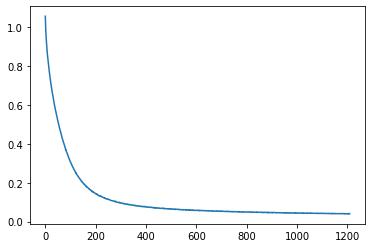

In [18]:
plt.plot(losses)

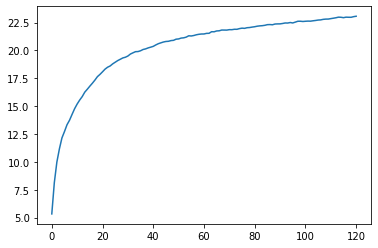

In [19]:
plt.plot(test_scores)

In [20]:
# Testing the best checkpoint on test dataset
storage.load_checkpoint("checkpoint.tar", model, optimizer)
best_model = model.to(device)
best_model.eval()
scores = test(model=best_model, data_generator=test_generator, entities_count=len(entity2id), device=device,
              summary_writer=summary_writer, epoch_id=1, metric_suffix="test")
print("Test scores: ", scores)

Test scores:  (7.583308902570117, 13.495553601094498, 22.798788234144435, 12.778492546100182)
